# CFB Predictions

## Data Source:

collegefootballdata.com

### Query Parameters

Player-PPA.csv: "Player Predicted Points Added by Season", Minimum of 1 snap (Threshold), Exclude Garbage Time

Player-Snaps.csv: "Player Usage metrics by season", Exclude Garbage Time

Team-Plays.csv: "Advanced Team Metrics by season", Exclude Garbage Time, Add Games manually

2023-Games.csv: "Games and Results", Division = fbs

SRS.csv: "Historical SRS Ratings", Year = 2023

Betting-Lines.csv: "Betting lines", Year = 2023

In [246]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy as sp

In [257]:
#Code Cell for function definitions
def elo_win_prob(home_elo, away_elo):
    elo_diff = home_elo - away_elo
    s = 400 #Scaling factor
    return 1/(1+10**(-elo_diff/s))

def expected_value_ml(home_elo_win_pct, home_ml, away_ml):
    home_ev = home_elo_win_pct * home_ml - (1-home_elo_win_pct)
    away_ev = (1-home_elo_win_pct) * away_ml - home_elo_win_pct
    return home_ev, away_ev

def cubic(x, a, b, c, d):
    return a*(x**3) + b*(x**2) + c*x + d

def linear(x, a, b):
    return a*x + b

### Historical Games Dataframe

This dataframe contains all of the games for 2023, both past and future. Primarily focused on past games for score analysis and back-testing

In [293]:
hist_games = pd.read_csv("2023-Games.csv")
week6 = hist_games[hist_games["Week"] == 6]
week6 = week6.dropna().reset_index(drop=True) #Apparently I'm running an old pandas version
week6["Home Win Prob"] = elo_win_prob(week6["Home Pregame Elo"], week6["Away Pregame Elo"])
hist_games = hist_games.dropna().reset_index(drop=True) #Removes future games from historical dataset
hist_games.tail()

,Id,Week,Neutral Site,Home Team,Home Conference,Home Points,Home Pregame Elo,Away Team,Away Conference,Away Points,Away Pregame Elo
267,401532589,5,False,Air Force,Mountain West,49.0,1722,San Diego State,Mountain West,10.0,1436.0
268,401531882,5,False,Louisiana Monroe,Sun Belt,40.0,1173,Appalachian State,Sun Belt,41.0,1574.0
269,401520285,5,False,Mississippi State,SEC,17.0,1551,Alabama,SEC,40.0,1959.0
270,401524021,5,False,Arizona,Pac-12,24.0,1446,Washington,Pac-12,31.0,1920.0
271,401532587,5,False,Fresno State,Mountain West,27.0,1787,Nevada,Mountain West,9.0,1214.0


### Player PPA Dataframe

This dataframe contains every player's Average Rush and Pass PPA (Predicted Points Added), as well as how many countable plays these figures are based on. 
 * Columns: Name, Position, Team, Conference, CountablePlays, AveragePPA Pass, AveragePPA Rush

In [133]:
player_ppa = pd.read_csv("Player-PPA.csv")
player_ppa.head()

,Season,Name,Position,Team,Conference,CountablePlays,AveragePPA Pass,AveragePPA Rush
0,2023,Joseph Bearns III,TE,Charlotte,American Athletic,1,-4.214,NaN
1,2023,Dante Lang,TE,Florida,SEC,1,-3.718,NaN
2,2023,Stephan Bracey,WR,Central Michigan,Mid-American,1,NaN,-2.523
3,2023,Cole Kramer,QB,Minnesota,Big Ten,2,-4.063,-0.157
4,2023,Cam'Ron McCoy,QB,Eastern Michigan,Mid-American,1,NaN,-1.618


### Player Snaps Dataframe

This dataframe contains every player's usage in games, where Pass Usage indicates what percentage of passing plays that player had a pass, incompletion, reception, or target, and Rush Usage indicates what percentage of rushing plays that player rushed.
 * Columns: Name, Position, Team, Conference, Usage Overall, Usage Pass, Usage Rush

In [134]:
player_snaps = pd.read_csv("Player-Snaps.csv")
player_snaps.head()

,Season,Name,Position,Team,Conference,Usage Overall,Usage Pass,Usage Rush
0,2023,Brayden Schager,QB,Hawai'i,Mountain West,0.7173,0.9862,0.1981
1,2023,Shedeur Sanders,QB,Colorado,Pac-12,0.7057,0.9842,0.1304
2,2023,Jacob Zeno,QB,UAB,American Athletic,0.6982,0.9942,0.2477
3,2023,Austin Reed,QB,Western Kentucky,Conference USA,0.6770,0.9518,0.1778
4,2023,Nick Vattiato,QB,Middle Tennessee,Conference USA,0.6754,0.9867,0.2845


### Team Plays Dataframe

This dataframe contains how many offensive plays each team has run, how many games they've played so far this season (manually added to the csv), how many of those plays were rushing or passing plays, and the defensive rushing and pass PPA.
 * Queried Columns: Team, Conference, Offense Plays, Offense RushingPlays Rate, Offense PassingPlays Rate, Defense RushingPlays Ppa, Defense PassingPlays Ppa
 * Manually added column: Games (Look at automating via hist_games)
 * Calculated Columns: Tempo, Pass Snaps, Rush Snaps

In [135]:
team_plays = pd.read_csv("Team-Plays.csv")
team_plays["Tempo"] = team_plays["Offense Plays"]/team_plays["Games"] #Tempo: Avg. Offensive plays run per game
team_plays["Pass Snaps"] = team_plays["Tempo"]*team_plays["Offense PassingPlays Rate"]
team_plays["Rush Snaps"] = team_plays["Tempo"]*team_plays["Offense RushingPlays Rate"]
team_plays.head()

,Season,Team,Conference,Games,Offense Plays,Offense Drives,Offense Ppa,Offense RushingPlays Rate,Offense RushingPlays Ppa,Offense PassingPlays Rate,Offense PassingPlays Ppa,Defense RushingPlays Ppa,Defense PassingPlays Ppa,Tempo,Pass Snaps,Rush Snaps
0,2023,Boston College,ACC,4,245,42,0.226704,0.530612,0.267366,0.465306,0.187709,0.119299,0.631994,61.25,28.50,32.50
1,2023,Clemson,ACC,4,260,43,0.242673,0.469231,0.216689,0.530769,0.265644,0.043752,0.007715,65.00,34.50,30.50
2,2023,Duke,ACC,4,204,35,0.377522,0.500000,0.415066,0.500000,0.339979,0.073611,-0.058060,51.00,25.50,25.50
3,2023,Florida State,ACC,4,232,43,0.283487,0.469828,0.039358,0.530172,0.499828,0.039066,0.207319,58.00,30.75,27.25
4,2023,Georgia Tech,ACC,4,109,22,0.430178,0.495413,0.254235,0.495413,0.659458,0.143151,0.242273,27.25,13.50,13.50


### SRS Dataframe

This dataframe contains each team's SRS (Simple Rating System), which is essentially a measure of how far above or below average each team is. A team's margin of victory can theoretically be estimated by subtracting their opponent's SRS from their own SRS

In [136]:
SRS = pd.read_csv("SRS.csv")
SRS.head()

,Year,Team,Conference,Division,Rating,Ranking
0,2023,Penn State,Big Ten,East,29.5,1
1,2023,Oregon,Pac-12,NaN,28.8,2
2,2023,Washington,Pac-12,NaN,28.4,3
3,2023,Texas,Big 12,NaN,24.7,4
4,2023,Miami,ACC,Coastal,22.4,5


### Betting Lines

This dataframe contains historical and current betting lines for college football games

In [205]:
betting_lines = pd.read_csv("Betting-Lines.csv")
betting_lines = betting_lines[betting_lines["LineProvider"] == "DraftKings"]
betting_lines.drop(columns="Id",inplace=True)
betting_lines = betting_lines.reset_index(drop=True)
betting_lines.columns = ["Home Team", "Away Team","LineProvider","OverUnder","Spread","HomeMl","AwayMl"]
#Convert American odds to decimal odds for ease of future calculations
betting_lines["HomeMl"] = np.where(betting_lines["HomeMl"] < 0, 100/np.abs(betting_lines["HomeMl"]), betting_lines["HomeMl"]/100)
betting_lines["AwayMl"] = np.where(betting_lines["AwayMl"] < 0, 100/np.abs(betting_lines["AwayMl"]), betting_lines["AwayMl"]/100)
betting_lines.head()

,Home Team,Away Team,LineProvider,OverUnder,Spread,HomeMl,AwayMl
0,Sam Houston State,Jacksonville State,DraftKings,36.5,6.5,2.050000,0.4
1,BYU,Sam Houston State,DraftKings,46.5,-20.0,0.083333,8.5
2,Indiana,Indiana State,DraftKings,45.5,-31.0,NaN,NaN
3,Army,Delaware State,DraftKings,44.0,-39.5,NaN,NaN
4,Ohio State,Youngstown State,DraftKings,56.5,-45.0,NaN,NaN


## Player Predictive Model

In [ ]:
class PlayerPredictiveModel:
    '''Model to predict the outcomes of CFB games using player-level PPA data
    
    Attributes:
        player_ppa: A pandas dataframe containing each players average pass/rush PPA, countable snaps
        player_snaps: A pandas dataframe containing each players pass/rush usage
        team_plays: A pandas dataframe containing each teams pass/rush play data, pass/rush defense PPA'''
    
    def __init__(self, ppa_data="Player-PPA.csv", snap_data="Player-Snaps.csv", team_data="Team-Plays.csv"):
        '''Initialize the model with current data
        
        Args:
            ppa_data: String for csv file containing player_ppa data
            snap_data: String for csv file containing player_snap data
            team_data: String for csv file containing team_plays data'''
        #Load data from provided files
        self.player_ppa = pd.read_csv(ppa_data)
        self.player_snaps = pd.read_csv(snap_data) 
        self.team_plays = pd.read_csv(team_data)
        #Calculate tempo and average number of pass/rush snaps per team
        self.team_plays["Tempo"] = self.team_plays["Offense Plays"]/self.team_plays["Games"] #Tempo: Avg. Offensive plays/game
        self.team_plays["Pass Snaps"] = self.team_plays["Tempo"]*self.team_plays["Offense PassingPlays Rate"]
        self.team_plays["Rush Snaps"] = self.team_plays["Tempo"]*self.team_plays["Offense RushingPlays Rate"]

        
    

In [294]:
set(team_plays["Team"])

{'Air Force',
 'Akron',
 'Alabama',
 'Appalachian State',
 'Arizona',
 'Arizona State',
 'Arkansas',
 'Arkansas State',
 'Army',
 'Auburn',
 'BYU',
 'Ball State',
 'Baylor',
 'Boise State',
 'Boston College',
 'Bowling Green',
 'Buffalo',
 'California',
 'Central Michigan',
 'Charlotte',
 'Cincinnati',
 'Clemson',
 'Coastal Carolina',
 'Colorado',
 'Colorado State',
 'Connecticut',
 'Duke',
 'East Carolina',
 'Eastern Michigan',
 'Florida',
 'Florida Atlantic',
 'Florida International',
 'Florida State',
 'Fresno State',
 'Georgia',
 'Georgia Southern',
 'Georgia State',
 'Georgia Tech',
 "Hawai'i",
 'Houston',
 'Illinois',
 'Indiana',
 'Iowa',
 'Iowa State',
 'Jacksonville State',
 'James Madison',
 'Kansas',
 'Kansas State',
 'Kent State',
 'Kentucky',
 'LSU',
 'Liberty',
 'Louisiana',
 'Louisiana Monroe',
 'Louisiana Tech',
 'Louisville',
 'Marshall',
 'Maryland',
 'Memphis',
 'Miami',
 'Miami (OH)',
 'Michigan',
 'Michigan State',
 'Middle Tennessee',
 'Minnesota',
 'Mississippi St

## Data Manipulation

In [137]:
passes = [] #List so pandas doesn't yell at us
rushes = []
for i in range(player_snaps.shape[0]):
    pass_snaps = float(team_plays[team_plays["Team"] == player_snaps["Team"].loc[i]]["Pass Snaps"]) #Lookup team rush/pass snaps
    rush_snaps = float(team_plays[team_plays["Team"] == player_snaps["Team"].loc[i]]["Rush Snaps"]) #Float conversions cause pandas
    passes.append(pass_snaps * float(player_snaps["Usage Pass"].loc[i])) #Calculate average player rush/pass snaps per game
    rushes.append(pass_snaps * float(player_snaps["Usage Rush"].loc[i]))
    
player_snaps["Pass Snaps"] = passes
player_snaps["Rush Snaps"] = rushes
player_snaps.head()

,Season,Name,Position,Team,Conference,Usage Overall,Usage Pass,Usage Rush,Pass Snaps,Rush Snaps
0,2023,Brayden Schager,QB,Hawai'i,Mountain West,0.7173,0.9862,0.1981,38.067320,7.646660
1,2023,Shedeur Sanders,QB,Colorado,Pac-12,0.7057,0.9842,0.1304,41.090350,5.444200
2,2023,Jacob Zeno,QB,UAB,American Athletic,0.6982,0.9942,0.2477,36.288300,9.041050
3,2023,Austin Reed,QB,Western Kentucky,Conference USA,0.6770,0.9518,0.1778,35.930450,6.711950
4,2023,Nick Vattiato,QB,Middle Tennessee,Conference USA,0.6754,0.9867,0.2845,34.287825,9.886375


In [138]:
temp_snaps = player_snaps.drop(columns=["Season","Position","Team","Conference","Usage Overall","Usage Pass", "Usage Rush"])
player_ppa = player_ppa.merge(temp_snaps, on="Name")
player_ppa = player_ppa.fillna(0) #Replace NaN with 0
player_ppa.head()

,Season,Name,Position,Team,Conference,CountablePlays,AveragePPA Pass,AveragePPA Rush,Pass Snaps,Rush Snaps
0,2023,Joseph Bearns III,TE,Charlotte,American Athletic,1,-4.214,0.000,0.23735,0.000000
1,2023,Dante Lang,TE,Florida,SEC,1,-3.718,0.000,0.23240,0.000000
2,2023,Stephan Bracey,WR,Central Michigan,Mid-American,1,0.000,-2.523,0.00000,0.152425
3,2023,Cole Kramer,QB,Minnesota,Big Ten,2,-4.063,-0.157,0.24920,0.193200
4,2023,Cam'Ron McCoy,QB,Eastern Michigan,Mid-American,1,0.000,-1.618,0.00000,0.280500


In [208]:
home_off = []
away_off = []
for i in range(week5.shape[0]):
    home = week5["Home Team"].loc[i]
    away = week5["Away Team"].loc[i]
    home_players = player_ppa[player_ppa["Team"] == home]
    away_players = player_ppa[player_ppa["Team"] == away]
    home_pts = home_players["Pass Snaps"]*home_players["AveragePPA Pass"] + home_players["Rush Snaps"]*home_players["AveragePPA Rush"]
    away_pts = away_players["Pass Snaps"]*away_players["AveragePPA Pass"] + away_players["Rush Snaps"]*away_players["AveragePPA Rush"]
    home_off.append(home_pts.sum())
    away_off.append(away_pts.sum())
    
    
week5["Raw Offense (Home)"] = home_off
week5["Raw Offense (Away)"] = away_off
week5.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Division,Home Pregame Elo,Away Team,Away Conference,Away Division,Away Pregame Elo,Home Win Prob,Raw Offense (Home),Raw Offense (Away)
0,2023,5,regular,False,Skelly Field at H. A. Chapman Stadium,Tulsa,American Athletic,fbs,1294,Temple,American Athletic,fbs,1139.0,0.709355,21.288642,34.994974
1,2023,5,regular,False,Houchens Industries-L. T. Smith Stadium,Western Kentucky,Conference USA,fbs,1506,Middle Tennessee,Conference USA,fbs,1320.0,0.744730,32.554932,33.716632
2,2023,5,regular,False,Bowers Stadium,Sam Houston State,Conference USA,fbs,1396,Jacksonville State,Conference USA,fbs,1505.0,0.348088,-3.716954,13.563470
3,2023,5,regular,False,Carter-Finley Stadium,NC State,ACC,fbs,1520,Louisville,ACC,fbs,1682.0,0.282408,23.891467,32.006050
4,2023,5,regular,False,Sun Bowl Stadium,UTEP,Conference USA,fbs,1210,Louisiana Tech,Conference USA,fbs,1211.0,0.498561,23.169687,27.676378


In [209]:
home_pts = []
away_pts = []
for i in range(week5.shape[0]):
    home = team_plays[team_plays["Team"] == week5["Home Team"].loc[i]] #Combine this cell and the one above for neatness
    away = team_plays[team_plays["Team"] == week5["Away Team"].loc[i]]
    #Functionize the below lines, so they're not so godawful
    home_def = float(home["Defense PassingPlays Ppa"])*float(away["Pass Snaps"]) + float(home["Defense RushingPlays Ppa"])*float(away["Rush Snaps"])
    away_def = float(away["Defense PassingPlays Ppa"])*float(home["Pass Snaps"]) + float(away["Defense RushingPlays Ppa"])*float(home["Rush Snaps"])
    home_pts.append(week5["Raw Offense (Home)"].loc[i] + away_def)
    away_pts.append(week5["Raw Offense (Away)"].loc[i] + home_def)
    
week5["Home Pts"] = home_pts
week5["Away Pts"] = away_pts
week5.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Division,Home Pregame Elo,Away Team,Away Conference,Away Division,Away Pregame Elo,Home Win Prob,Raw Offense (Home),Raw Offense (Away),Home Pts,Away Pts
0,2023,5,regular,False,Skelly Field at H. A. Chapman Stadium,Tulsa,American Athletic,fbs,1294,Temple,American Athletic,fbs,1139.0,0.709355,21.288642,34.994974,34.847016,58.896835
1,2023,5,regular,False,Houchens Industries-L. T. Smith Stadium,Western Kentucky,Conference USA,fbs,1506,Middle Tennessee,Conference USA,fbs,1320.0,0.744730,32.554932,33.716632,49.951576,53.003545
2,2023,5,regular,False,Bowers Stadium,Sam Houston State,Conference USA,fbs,1396,Jacksonville State,Conference USA,fbs,1505.0,0.348088,-3.716954,13.563470,-1.920000,22.565701
3,2023,5,regular,False,Carter-Finley Stadium,NC State,ACC,fbs,1520,Louisville,ACC,fbs,1682.0,0.282408,23.891467,32.006050,31.035986,37.781852
4,2023,5,regular,False,Sun Bowl Stadium,UTEP,Conference USA,fbs,1210,Louisiana Tech,Conference USA,fbs,1211.0,0.498561,23.169687,27.676378,33.999256,45.180891


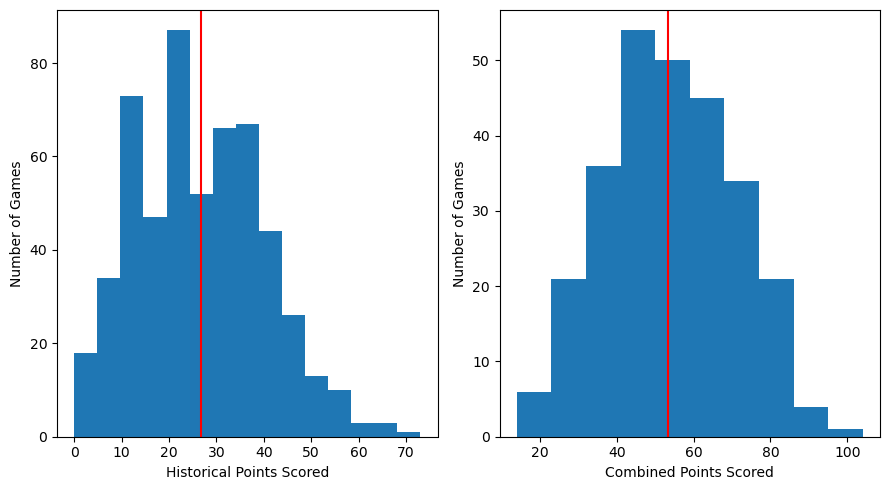

In [288]:
hist_games["Total"] = hist_games["Home Points"] + hist_games["Away Points"]
results = np.concatenate((hist_games["Home Points"].to_numpy(),hist_games["Away Points"].to_numpy()),axis=None)
avg_total = np.mean(results)
total_std = np.std(results)
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.hist(results,bins=15)
plt.axvline(avg_total,c="r")
plt.xlabel("Historical Points Scored")
plt.ylabel("Number of Games")
plt.subplot(1,2,2)
plt.hist(hist_games["Total"])
plt.axvline(np.mean(hist_games["Total"]),c="r")
plt.xlabel("Combined Points Scored")
plt.ylabel("Number of Games")
plt.tight_layout()

Data Scaling Idea found here: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation

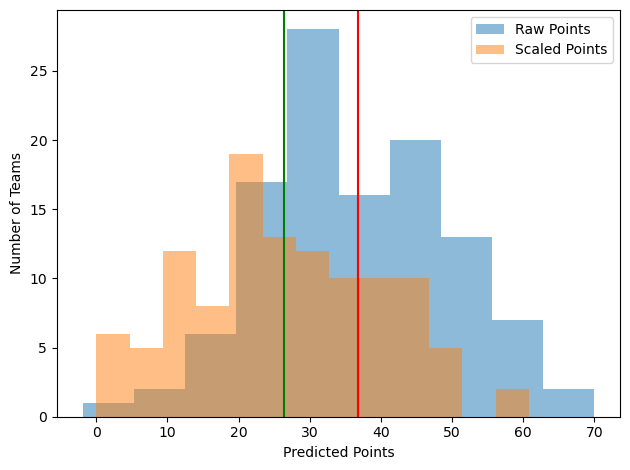

In [211]:
week5["Total"] = week5["Home Pts"] + week5["Away Pts"]
preds = np.concatenate((week5["Home Pts"].to_numpy(),week5["Away Pts"].to_numpy()),axis=None)
pred_avg = np.mean(preds)
pred_std = np.std(preds)
plt.hist(preds,alpha=0.5,label="Raw Points")
plt.axvline(pred_avg,c="r")
plt.xlabel("Predicted Points")
plt.ylabel("Number of Teams")
scaled_preds = avg_total + (preds-pred_avg)*(total_std/pred_std)
scaled_preds[scaled_preds < 0] = 0
plt.hist(scaled_preds,bins=13,alpha=0.5,label="Scaled Points")
plt.axvline(np.mean(scaled_preds),c="g")
plt.legend()
plt.tight_layout()

In [212]:
home, away = np.split(scaled_preds,2)
week5["Home Pts"] = home.astype(int)
week5["Away Pts"] = away.astype(int)
week5["Total"] = week5["Home Pts"] + week5["Away Pts"]
week5.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Division,Home Pregame Elo,Away Team,Away Conference,Away Division,Away Pregame Elo,Home Win Prob,Raw Offense (Home),Raw Offense (Away),Home Pts,Away Pts,Total
0,2023,5,regular,False,Skelly Field at H. A. Chapman Stadium,Tulsa,American Athletic,fbs,1294,Temple,American Athletic,fbs,1139.0,0.709355,21.288642,34.994974,24,49,73
1,2023,5,regular,False,Houchens Industries-L. T. Smith Stadium,Western Kentucky,Conference USA,fbs,1506,Middle Tennessee,Conference USA,fbs,1320.0,0.744730,32.554932,33.716632,40,43,83
2,2023,5,regular,False,Bowers Stadium,Sam Houston State,Conference USA,fbs,1396,Jacksonville State,Conference USA,fbs,1505.0,0.348088,-3.716954,13.563470,0,11,11
3,2023,5,regular,False,Carter-Finley Stadium,NC State,ACC,fbs,1520,Louisville,ACC,fbs,1682.0,0.282408,23.891467,32.006050,20,27,47
4,2023,5,regular,False,Sun Bowl Stadium,UTEP,Conference USA,fbs,1210,Louisiana Tech,Conference USA,fbs,1211.0,0.498561,23.169687,27.676378,23,35,58


In [213]:
home_srs = []
away_srs = []
for i in range(week5.shape[0]):
    home = SRS[SRS["Team"] == week5["Home Team"].loc[i]] #Combine this cell and the one above for neatness
    away = SRS[SRS["Team"] == week5["Away Team"].loc[i]]
    #Functionize the below lines, so they're not so godawful
    home_srs.append(float(home["Rating"]))
    away_srs.append(float(away["Rating"]))
    
week5["Home SRS"] = home_srs
week5["Away SRS"] = away_srs
week5["SRS Spread"] = week5["Away SRS"] - week5["Home SRS"]
week5.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Division,Home Pregame Elo,Away Team,...,Away Pregame Elo,Home Win Prob,Raw Offense (Home),Raw Offense (Away),Home Pts,Away Pts,Total,Home SRS,Away SRS,SRS Spread
0,2023,5,regular,False,Skelly Field at H. A. Chapman Stadium,Tulsa,American Athletic,fbs,1294,Temple,...,1139.0,0.709355,21.288642,34.994974,24,49,73,-4.7,-8.9,-4.2
1,2023,5,regular,False,Houchens Industries-L. T. Smith Stadium,Western Kentucky,Conference USA,fbs,1506,Middle Tennessee,...,1320.0,0.744730,32.554932,33.716632,40,43,83,0.4,-3.8,-4.2
2,2023,5,regular,False,Bowers Stadium,Sam Houston State,Conference USA,fbs,1396,Jacksonville State,...,1505.0,0.348088,-3.716954,13.563470,0,11,11,-13.2,-9.1,4.1
3,2023,5,regular,False,Carter-Finley Stadium,NC State,ACC,fbs,1520,Louisville,...,1682.0,0.282408,23.891467,32.006050,20,27,47,-5.2,12.2,17.4
4,2023,5,regular,False,Sun Bowl Stadium,UTEP,Conference USA,fbs,1210,Louisiana Tech,...,1211.0,0.498561,23.169687,27.676378,23,35,58,-17.6,-17.3,0.3


## Initial Observations

Exploratory Analysis done in an excel workbook for ease of manipulation and visualization
* Initial predictions are decent at predicting winners (~70% prediction accuracy)
* Point differential pedictions are okay (16.7% within 3 points, 33.3% within 7 points)
* Predicting exact points tends to overshoot actual points, introduce scaling factor to reduce predicted score (Unsure whether to apply to raw offense or final predicted points)
* Manually scaling performs poorly, maybe use machine learning to determine optimal scaling
* Adjusting player snap threshold doesn't have a significant effect on outcomes, which makes sense as players with very few snaps have a very small impact on the game

## Back-Testing

In [289]:
hist_games["Elo Win Pct"] = elo_win_prob(hist_games["Home Pregame Elo"], hist_games["Away Pregame Elo"])
hist_games.head()

,Id,Week,Neutral Site,Home Team,Home Conference,Home Points,Home Pregame Elo,Away Team,Away Conference,Away Points,Away Pregame Elo,Total,Elo Win Pct
0,401525434,1,True,Notre Dame,FBS Independents,42.0,1733,Navy,American Athletic,3.0,1471.0,45.0,0.818793
1,401520145,1,False,Jacksonville State,Conference USA,17.0,1500,UTEP,Conference USA,14.0,1369.0,31.0,0.680071
2,401532392,1,False,San Diego State,Mountain West,20.0,1488,Ohio,Mid-American,13.0,1482.0,33.0,0.508634
3,401525450,1,False,New Mexico State,Conference USA,30.0,1322,UMass,FBS Independents,41.0,1074.0,71.0,0.806528
4,401520147,1,False,Vanderbilt,SEC,35.0,1322,Hawai'i,Mountain West,28.0,1246.0,63.0,0.607661


In [290]:
hist_games["Elo Accuracy"] = np.where(((hist_games["Elo Win Pct"]>0.5)&(hist_games["Home Points"]>hist_games["Away Points"])) |
         ((hist_games["Elo Win Pct"]<0.5)&(hist_games["Home Points"]<hist_games["Away Points"])), 1, 0)
print("Elo Accuracy: {:.2%}, Sample size: {}".format(np.mean(hist_games["Elo Accuracy"]), len(hist_games["Elo Accuracy"])))

Elo Accuracy: 76.10%, Sample size: 272


In [216]:
hist_games = pd.merge(hist_games, betting_lines, how="left",on=["Home Team","Away Team"])
hist_games.drop(columns="LineProvider", inplace=True) #Since we're only using DraftKings lines
hist_games.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Points,Home Post Win Prob,Home Pregame Elo,...,Away Post Win Prob,Away Pregame Elo,Away Postgame Elo,Total,Elo Win Pct,Elo Accuracy,OverUnder,Spread,HomeMl,AwayMl
0,2023,1,regular,True,Aviva Stadium,Notre Dame,FBS Independents,42.0,0.998958,1733,...,0.001042,1471.0,1385.0,45.0,0.818793,1,50.5,-20.0,0.074074,8.000000
1,2023,1,regular,False,JSU Stadium,Jacksonville State,Conference USA,17.0,0.408001,1500,...,0.591999,1369.0,1370.0,31.0,0.680071,1,51.5,NaN,0.909091,0.909091
2,2023,1,regular,False,Aggie Memorial Stadium,New Mexico State,Conference USA,30.0,0.239249,1322,...,0.760751,1074.0,1122.0,71.0,0.806528,0,42.5,-8.0,0.307692,2.600000
3,2023,1,regular,False,Snapdragon Stadium,San Diego State,Mountain West,20.0,0.954469,1488,...,0.045531,1482.0,1473.0,33.0,0.508634,1,49.0,-3.5,0.617284,1.360000
4,2023,1,regular,False,Vanderbilt Stadium,Vanderbilt,SEC,35.0,0.180846,1322,...,0.819154,1246.0,1241.0,63.0,0.607661,1,54.5,-18.0,0.095238,6.750000


In [217]:
week5 = pd.merge(week5, betting_lines, how="left", on=["Home Team", "Away Team"])
week5.drop(columns = ["LineProvider","Home Division", "Away Division"], inplace=True)
week5.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Pregame Elo,Away Team,Away Conference,...,Home Pts,Away Pts,Total,Home SRS,Away SRS,SRS Spread,OverUnder,Spread,HomeMl,AwayMl
0,2023,5,regular,False,Skelly Field at H. A. Chapman Stadium,Tulsa,American Athletic,1294,Temple,American Athletic,...,24,49,73,-4.7,-8.9,-4.2,54.5,-3.5,0.555556,1.500000
1,2023,5,regular,False,Houchens Industries-L. T. Smith Stadium,Western Kentucky,Conference USA,1506,Middle Tennessee,Conference USA,...,40,43,83,0.4,-3.8,-4.2,59.5,-5.5,0.434783,1.900000
2,2023,5,regular,False,Bowers Stadium,Sam Houston State,Conference USA,1396,Jacksonville State,Conference USA,...,0,11,11,-13.2,-9.1,4.1,36.5,6.5,2.050000,0.400000
3,2023,5,regular,False,Carter-Finley Stadium,NC State,ACC,1520,Louisville,ACC,...,20,27,47,-5.2,12.2,17.4,55.5,3.5,1.420000,0.588235
4,2023,5,regular,False,Sun Bowl Stadium,UTEP,Conference USA,1210,Louisiana Tech,Conference USA,...,23,35,58,-17.6,-17.3,0.3,53.0,-1.0,0.869565,0.952381


In [275]:
week5.to_csv("Week5-Predictions.csv")

In [221]:
hist_games["HomeEV"], hist_games["AwayEV"] = expected_value_ml(hist_games["Elo Win Pct"],hist_games["HomeMl"],hist_games["AwayMl"])

-55.47157919697009

In [240]:
x = 0.1 #Expected value cutoff needed to place a moneyline bet

home_bets = np.where(hist_games["HomeEV"]<=x,0,np.where(hist_games["Home Points"]>hist_games["Away Points"],hist_games["HomeMl"],-1))
away_bets = np.where(hist_games["AwayEV"]<=x,0,np.where(hist_games["Home Points"]<hist_games["Away Points"],hist_games["AwayMl"],-1))

print("Average Return on Home Bets: {:.2%}, Sample Size: {}".format(np.nanmean(home_bets), np.count_nonzero(home_bets)))
print("Average Return on Away Bets: {:.2%}, Sample Size: {}".format(np.nanmean(away_bets), np.count_nonzero(away_bets)))

Average Return on Home Bets: -13.39%, Sample Size: 79
Average Return on Away Bets: -30.16%, Sample Size: 142


Text(0, 0.5, 'Posted Home Spread')

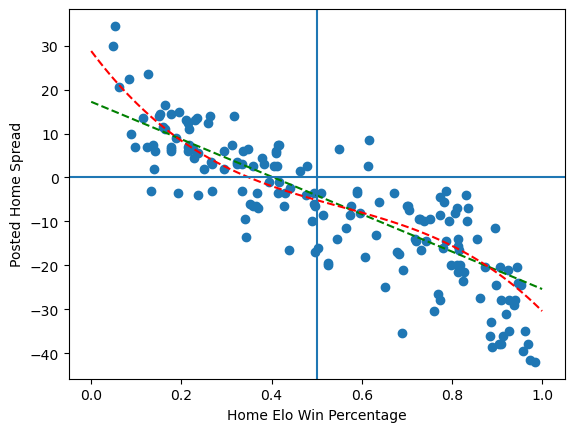

In [266]:
temp_fit = hist_games.dropna().reset_index(drop=True)
cof, cov = sp.optimize.curve_fit(cubic, temp_fit["Elo Win Pct"], temp_fit["Spread"])
x = np.linspace(0,1,100)
lin_cof, cov = sp.optimize.curve_fit(linear, temp_fit["Elo Win Pct"], temp_fit["Spread"])
plt.plot(x, linear(x,*lin_cof),"--g")
plt.plot(x, cubic(x,*cof),"--r")
plt.scatter(hist_games["Elo Win Pct"], hist_games["Spread"])
plt.axhline(0)
plt.axvline(0.5)
plt.xlabel("Home Elo Win Percentage")
plt.ylabel("Posted Home Spread")

Interestingly enough, the spread for a home team that has a 50% elo win probability is significantly below 0 (-4 for the linear regression and -5 for the cubic). This could be representative of a lack of elo accuracy, however we have already established that elo is a reasonably accurate predictor of outcomes, with a ~76% success rate. It's more likely that this represents sportsbooks' accounting for home field advantage in setting their lines, as elo makes no distinction between home and away teams.

Text(0, 0.5, 'Actual Home Spread')

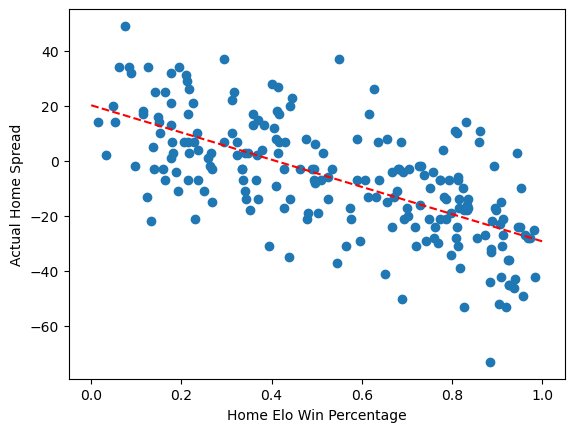

In [269]:
cof, cov = sp.optimize.curve_fit(linear, hist_games["Elo Win Pct"], hist_games["Away Points"] - hist_games["Home Points"])
x = np.linspace(0,1,100)
plt.scatter(hist_games["Elo Win Pct"], hist_games["Away Points"] - hist_games["Home Points"])
plt.plot(x,linear(x,*cof),"--r")
plt.xlabel("Home Elo Win Percentage")
plt.ylabel("Actual Home Spread")

Interestingly the bias towards home teams is reflected in the actual outcomes of games as well. In games where the home elo win percentage is 50%, the home team typically outscores the away team by 4.5 points.

In [272]:
#Predict home spread based on Linear regression of elo win percentage
hist_games["Elo Spread"] = linear(hist_games["Elo Win Pct"], *cof)
hist_games

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Points,Home Post Win Prob,Home Pregame Elo,...,Total,Elo Win Pct,Elo Accuracy,OverUnder,Spread,HomeMl,AwayMl,HomeEV,AwayEV,Elo Spread
0,2023,1,regular,True,Aviva Stadium,Notre Dame,FBS Independents,42.0,0.998958,1733,...,45.0,0.818793,1,50.5,-20.0,0.074074,8.000000,-0.120555,0.630860,-20.250551
1,2023,1,regular,False,JSU Stadium,Jacksonville State,Conference USA,17.0,0.408001,1500,...,31.0,0.680071,1,51.5,NaN,0.909091,0.909091,0.298317,-0.389226,-13.398536
2,2023,1,regular,False,Aggie Memorial Stadium,New Mexico State,Conference USA,30.0,0.239249,1322,...,71.0,0.806528,0,42.5,-8.0,0.307692,2.600000,0.054690,-0.303499,-19.644700
3,2023,1,regular,False,Snapdragon Stadium,San Diego State,Mountain West,20.0,0.954469,1488,...,33.0,0.508634,1,49.0,-3.5,0.617284,1.360000,-0.177395,0.159624,-4.930646
4,2023,1,regular,False,Vanderbilt Stadium,Vanderbilt,SEC,35.0,0.180846,1322,...,63.0,0.607661,1,54.5,-18.0,0.095238,6.750000,-0.334466,2.040627,-9.821961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,2023,4,regular,False,Sun Bowl Stadium,UTEP,Conference USA,28.0,0.106234,1241,...,73.0,0.359935,1,50.0,2.5,0.869565,0.769231,-0.327078,0.132423,2.414132
211,2023,4,regular,False,Sun Devil Stadium,Arizona State,Pac-12,28.0,0.043227,1392,...,70.0,0.053531,1,62.0,34.5,50.000000,0.010000,1.730087,-0.044066,17.548535
212,2023,4,regular,False,Husky Stadium,Washington,Pac-12,59.0,0.998943,1888,...,91.0,0.874344,1,57.0,-20.5,0.095238,6.750000,-0.042385,-0.026168,-22.994414
213,2023,4,regular,False,Bulldog Stadium,Fresno State,Mountain West,53.0,0.997150,1723,...,63.0,0.940003,1,47.5,-28.0,0.025000,17.000000,-0.036497,0.079945,-26.237542


In [274]:
np.mean(np.where(hist_games["Elo Spread"]<hist_games["Spread"],np.where((hist_games["Away Points"]-hist_games["Home Points"])<hist_games["Spread"],100/110,-1),np.where((hist_games["Away Points"]-hist_games["Home Points"])>hist_games["Spread"],100/110,-1)))

-0.28964059196617337

While individual models may have difficulty predicting game outcomes, we can apply an ensemble model to improve our overall accuracy. In the below cell, we extract home and away games where the Player-Based Spread, SRS Spread, and Elo Spread all fall on the same side of the posted sportsbook spread, improving our confidence.

In [285]:
week5["Elo Spread"] = linear(week5["Home Win Prob"], *cof)
home_ensemble = (week5["Elo Spread"] < week5["Spread"]) & ((week5["Away Pts"]-week5["Home Pts"]) < week5["Spread"]) & (week5["SRS Spread"] < week5["Spread"])
away_ensemble = (week5["Elo Spread"] > week5["Spread"]) & ((week5["Away Pts"]-week5["Home Pts"]) > week5["Spread"]) & (week5["SRS Spread"] > week5["Spread"])
ensemble_bets = week5[home_ensemble | away_ensemble]
ensemble_bets

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Pregame Elo,Away Team,Away Conference,...,Away Pts,Total,Home SRS,Away SRS,SRS Spread,OverUnder,Spread,HomeMl,AwayMl,Elo Spread
3,2023,5,regular,False,Carter-Finley Stadium,NC State,ACC,1520,Louisville,ACC,...,27,47,-5.2,12.2,17.4,55.5,3.5,1.420000,0.588235,6.243459
6,2023,5,regular,False,LaVell Edwards Stadium,BYU,Big 12,1536,Cincinnati,Big 12,...,37,70,3.0,4.8,1.8,50.0,-2.5,0.704225,1.200000,-0.488413
7,2023,5,regular,False,Rentschler Field,Connecticut,FBS Independents,1168,Utah State,Mountain West,...,37,47,-17.7,-1.7,16.0,51.0,4.5,1.700000,0.487805,9.185412
12,2023,5,regular,False,TCF Bank Stadium,Minnesota,Big Ten,1635,Louisiana,Sun Belt,...,34,44,-2.8,-14.7,-11.9,47.5,-12.5,0.200000,3.800000,-9.889706
13,2023,5,regular,False,Bridgeforth Stadium,James Madison,Sun Belt,1590,South Alabama,Sun Belt,...,32,73,-0.4,-6.5,-6.1,51.5,-3.0,0.645161,1.300000,-9.481994
14,2023,5,regular,False,Folsom Field,Colorado,Pac-12,1252,USC,Pac-12,...,35,70,11.1,12.9,1.8,73.5,21.5,8.500000,0.068966,18.890753
25,2023,5,regular,False,Bobby Dodd Stadium at Historic Grant Field,Georgia Tech,ACC,1391,Bowling Green,Mid-American,...,20,40,3.0,-11.1,-14.1,52.5,-22.0,0.055556,10.000000,-17.125197
28,2023,5,regular,False,Maryland Stadium,Maryland,Big Ten,1687,Indiana,Big Ten,...,18,66,11.5,-9.5,-21.0,50.5,-14.0,0.160000,4.550000,-21.371741
29,2023,5,regular,False,Ross-Ade Stadium,Purdue,Big Ten,1432,Illinois,Big Ten,...,45,88,-5.6,-0.3,5.3,53.5,-1.0,0.869565,0.952381,6.643247
36,2023,5,regular,False,Liberty Bowl Memorial Stadium,Memphis,American Athletic,1558,Boise State,Mountain West,...,11,61,8.1,2.5,-5.6,60.0,-3.5,0.555556,1.500000,-5.640716


In [291]:
outcome = np.where(hist_games["Home Points"] > hist_games["Away Points"], 1,0)
elo_brier_score = np.mean((hist_games["Elo Win Pct"] - outcome)**2)
print("Elo Brier Score: {:.3f}".format(elo_brier_score))

Elo Brier Score: 0.168


We can see that the Elo Brier Score is less than 0.25, which corresponds to zero predictive confidence (0.5 on every game), indicating that the elo score does have predictive ability.